# Image captioning with visual attention

So what are the goals for today?
Given an image (Big purple dog is swimming in the seiling) create text output which will try at least to give a short discription to this miracle of nature.


To accomplish this, we are going to use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

Attention-based models belong to a class of models commonly called sequence-to-sequence models. The aim of these models, as name suggests, it to produce an output sequence given an input sequence which are, in general, of different lengths. 

In our case sequence of pixels -> sequens of words.

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 973s 0us/step


In [0]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector, random_state=1)

num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [0]:
len(train_captions), len(all_captions)

(30000, 414113)

For working on the code the size of (30000, 414113) is used. The dependance from the number of input features will be reflected in the conclusions.

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

InceptionV3 

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
from tqdm import tqdm

In [0]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

*Tokenizer:
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
max_length = calc_max_length(train_seqs)

Split the data

In [0]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [0]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Global attentional model** – at each timestept, the  model infers avariable-length alignment weight vector at based on the current target state and all source states. 

The global attention has a drawback that it has to attend to all words on the source side for each target word, which is expensive and can potentially render it impractical to translate longer sequences,e.g.,  paragraphs or documents. To address this deficiency,  was proposed a local attentional mechanism that chooses to focus only on a small subset of the source positions per target word.

**Local attention model** – the model first predicts a single aligned position for the current target word. A window centered around the source position is then used to compute a context vector, a weighted average of the source hidden states in the window. The weights are inferred from the current target state and those source states in the window.


There are mentioned the difference between two attentions as follows,

1. Luong attention used top hidden layer states in both of encoder and decoder. But Bahdanau attention take concatenation of forward and backward source hidden state (Top Hidden Layer).
2. In Luong attention they get the decoder hidden state at time t. Then calculate attention scores and from that get the context vector which will be concatenated with hidden state of the decoder and then predict.
3. But in the Bahdanau at time t we consider about t-1 hidden state of the decoder. Then we calculate alignment , context vectors as above. But then we concatenate this context with hidden state of the decoder at t-1. So before the softmax this concatenated vector goes inside a GRU.
4. Luong has diffferent types of alignments. Bahdanau has only concat score alignment model.


In [0]:
class BahdanauAttention(tf.keras.Model):
  """
    In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
    You squash that to a shape of (64, 2048).
    This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
    The RNN (here GRU) attends over the image to predict the next word.
  """
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

An encoder is a network (FC, CNN, RNN, etc) that takes the input, and output a feature map/vector/tensor. These feature vectors hold the information, the features, that represent the input. The decoder is again a network (usually the same network structure as encoder but in opposite orientation) that takes the feature vector from the encoder, and gives the best closest match to the actual input or intended output.

The encoders are trained with the decoders. There are no labels (hence unsupervised). The loss function is based on computing the delta between the actual and reconstructed input. The optimizer will try to train both encoder and decoder to lower this reconstruction loss.

Once trained, the encoder will gives feature vector for input that can be use by decoder to construct the input with the features that matter the most to make the reconstructed input recognizable as the actual input.

The same technique is being used in various different applications like in translation, generative models, etc[.](https://www.quora.com/What-is-an-Encoder-Decoder-in-Deep-Learning)

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


## A bit about layers used for decoder:

### Word Embedding

A word embedding is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.

The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

The position of a word in the learned vector space is referred to as its embedding.

Two popular examples of methods of learning word embeddings from text include:

- Word2Vec
- GloVe

In addition to these carefully designed methods, a word embedding can be learned as part of a deep learning model. This can be a slower approach, but tailors the model to a specific training dataset[.](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

### LSTM vs GPU
Recurrent networks like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Units) are powerful sequence models.

Recurrent Neural Networks suffer from short-term memory. If a sequence is long enough, they’ll have a hard time carrying information from earlier time steps to later ones. So if you are trying to process a paragraph of text to do predictions, RNN’s may leave out important information from the beginning (vanishing gradient problem). 

LSTM ’s and GRU’s were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information using some number of gates.
![LSTM vs GPU](https://miro.medium.com/max/1400/1*yBXV9o5q7L_CvY7quJt3WQ.png)
These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. Almost all state of the art results based on recurrent neural networks are achieved with these two networks. LSTM’s and GRU’s can be found in speech recognition, speech synthesis, and text generation. 

GRU’s has fewer tensor operations; therefore, they are a little speedier to train then LSTM’s.Also it's newer. There isn’t a clear winner which one is better. Researchers and engineers usually try both to determine which one works better for their use case[.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) 

Here we are using Gated Recurrent Units.

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Adam optimizer

**Adam** can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters. Its name is derived from adaptive moment estimation, and the reason it’s called that is because Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network. Now, what is moment ? N-th moment of a random variable is defined as the expected value of that variable to the power of n.

The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

- Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
- Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp[.](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

### Making a small checkpoint and start training

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9757
Epoch 1 Batch 100 Loss 1.1362
Epoch 1 Batch 200 Loss 1.0059
Epoch 1 Batch 300 Loss 0.9117
Epoch 1 Loss 1.042586
Time taken for 1 epoch 404.08918499946594 sec

Epoch 2 Batch 0 Loss 0.8064
Epoch 2 Batch 100 Loss 0.8214
Epoch 2 Batch 200 Loss 0.8117
Epoch 2 Batch 300 Loss 0.7207
Epoch 2 Loss 0.790960
Time taken for 1 epoch 383.1489999294281 sec

Epoch 3 Batch 0 Loss 0.7423
Epoch 3 Batch 100 Loss 0.7116
Epoch 3 Batch 200 Loss 0.6818
Epoch 3 Batch 300 Loss 0.6900
Epoch 3 Loss 0.720833
Time taken for 1 epoch 377.2487952709198 sec

Epoch 4 Batch 0 Loss 0.7049
Epoch 4 Batch 100 Loss 0.7254
Epoch 4 Batch 200 Loss 0.6860
Epoch 4 Batch 300 Loss 0.6175
Epoch 4 Loss 0.677698
Time taken for 1 epoch 377.5539560317993 sec

Epoch 5 Batch 0 Loss 0.6674
Epoch 5 Batch 100 Loss 0.7130
Epoch 5 Batch 200 Loss 0.6572
Epoch 5 Batch 300 Loss 0.6501
Epoch 5 Loss 0.641166
Time taken for 1 epoch 380.1713070869446 sec

Epoch 6 Batch 0 Loss 0.6526
Epoch 6 Batch 100 Loss 0.5966
Epoch 6 Bat

Well, it took some time (7570 seconds = 126 minutes to be precise). Still, I think totally worth it.

### The loss function and other conclusions

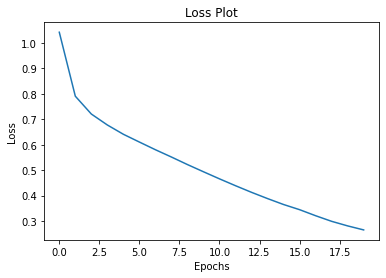

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Pic's number: 3311
Real Caption: <start> the man is taking a selfie in the bathroom mirror <end>
Prediction Caption: a man with glasses holding his cell phone <end>


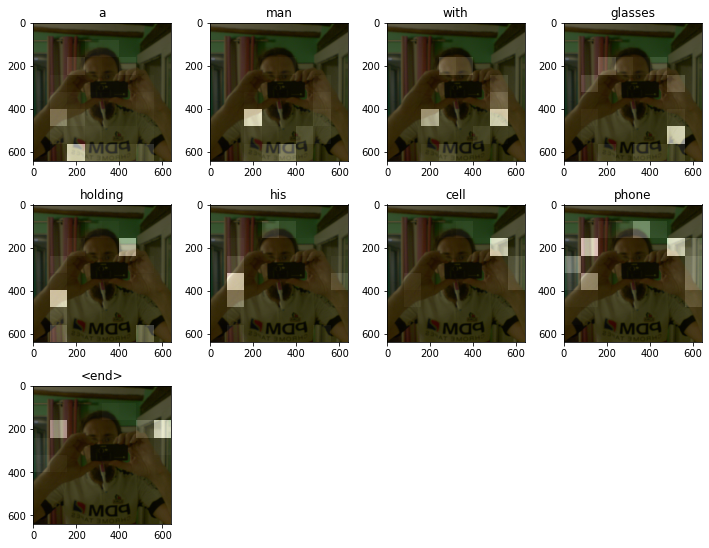

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


print ('Pic\'s number:', rid)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Well, isn't this amazing? Obviosly it's far from perfect and sometimes it gets some weird results, but as it's just a small model with 2 hours of training and it was trained on a relatively small amount of data, it works quite good.

Prediction Caption: an orange cat laying down in front of a <unk> <end>


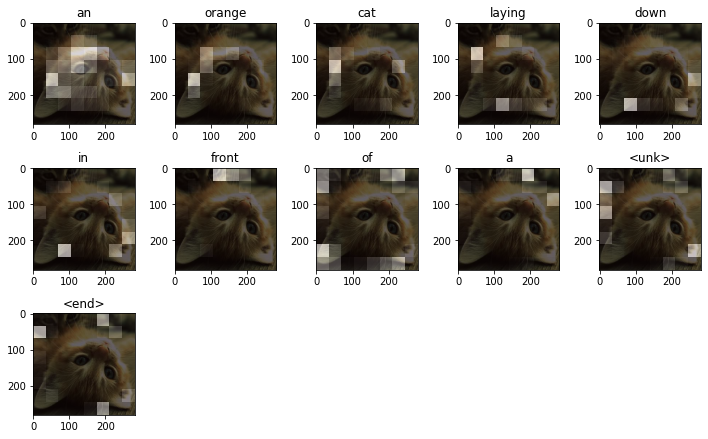

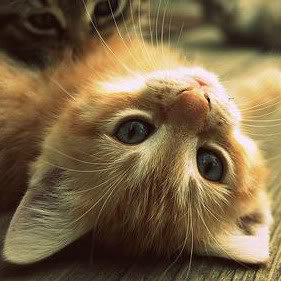

In [0]:
image_url = 'https://s3.amazonaws.com/freecodecamp/relaxing-cat.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


And it does work for a custom photos!

But I want to be honest, before I got this caption, this kitten was called 'blanket', 'horse' and 'toy'. Anyway, eventually it figured it out.

### Credits:


0. [Image captioning with visual attention](https://www.tensorflow.org/tutorials/text/image_captioning)
1. [Illustrated Guide to LSTM’s and GRU’s](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
2. [What is an Encoder/Decoder in Deep Learning?](https://www.quora.com/What-is-an-Encoder-Decoder-in-Deep-Learning)
3. [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
4. [Gentle Introduction to the Adam Optimization](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

In [55]:
print(ckpt_manager.checkpoints)

['./checkpoints/train/ckpt-1', './checkpoints/train/ckpt-2', './checkpoints/train/ckpt-3', './checkpoints/train/ckpt-4']


In [61]:
!zip -r /content/file.zip /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/train/ (stored 0%)
  adding: content/checkpoints/train/ckpt-2.index (deflated 69%)
  adding: content/checkpoints/train/ckpt-4.data-00000-of-00002 (deflated 8%)
  adding: content/checkpoints/train/ckpt-4.index (deflated 69%)
  adding: content/checkpoints/train/checkpoint (deflated 68%)
  adding: content/checkpoints/train/ckpt-3.data-00001-of-00002 (deflated 16%)
  adding: content/checkpoints/train/ckpt-2.data-00000-of-00002 (deflated 8%)
  adding: content/checkpoints/train/ckpt-1.data-00001-of-00002 (deflated 16%)
  adding: content/checkpoints/train/ckpt-3.data-00000-of-00002 (deflated 8%)
  adding: content/checkpoints/train/ckpt-1.data-00000-of-00002 (deflated 8%)
  adding: content/checkpoints/train/ckpt-4.data-00001-of-00002 (deflated 16%)
  adding: content/checkpoints/train/ckpt-1.index (deflated 69%)
  adding: content/checkpoints/train/ckpt-2.data-00001-of-00002 (deflated 16%)
  adding: content/checkpoints/trai

In [0]:
from google.colab import files

In [0]:
files.download('file.zip') 